In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import sys
sys.argv=['']
del sys
import torch.nn as nn
import torch.nn.functional as F
import torch
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=5000, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            *block(1024, 2048),
            nn.Linear(2048, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("/home/zhizuo/271B/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "/home/zhizuo/271B/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/cGAN_%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------
D_loss = np.zeros(opt.n_epochs)
G_loss = np.zeros(opt.n_epochs)
for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        D_loss[epoch] += d_loss
        G_loss[epoch] += g_loss
        d_loss.backward()
        optimizer_D.step()

        if i == 1:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        #if batches_done % opt.sample_interval == 0:
        if (epoch + 1) % 50 == 0 and epoch >= 1:
            sample_image(n_row=10, batches_done=epoch+1)
            
    D_loss[epoch] /= len(dataloader)
    G_loss[epoch] /= len(dataloader)
    
    if epoch == opt.n_epochs - 1:
        torch.save(generator.state_dict(), 
                  '/home/zhizuo/271B/cGAN_g_128_256_512_1024_1536.pkl')
        torch.save(discriminator.state_dict(), 
                  '/home/zhizuo/271B/cGAN_d_512_512_512_.pkl')

Namespace(b1=0.5, b2=0.999, batch_size=256, channels=1, img_size=32, latent_dim=100, lr=0.0002, n_classes=10, n_cpu=8, n_epochs=200, sample_interval=5000)
[Epoch 0/200] [Batch 1/235] [D loss: 0.359410] [G loss: 0.913896]
[Epoch 1/200] [Batch 1/235] [D loss: 0.159389] [G loss: 0.537122]
[Epoch 2/200] [Batch 1/235] [D loss: 0.306644] [G loss: 1.151661]
[Epoch 3/200] [Batch 1/235] [D loss: 0.146562] [G loss: 0.513219]
[Epoch 4/200] [Batch 1/235] [D loss: 0.140543] [G loss: 0.509698]
[Epoch 5/200] [Batch 1/235] [D loss: 0.144696] [G loss: 0.341102]
[Epoch 6/200] [Batch 1/235] [D loss: 0.123777] [G loss: 0.474059]
[Epoch 7/200] [Batch 1/235] [D loss: 0.216881] [G loss: 0.954161]
[Epoch 8/200] [Batch 1/235] [D loss: 0.161806] [G loss: 0.812249]
[Epoch 9/200] [Batch 1/235] [D loss: 0.121264] [G loss: 0.442743]
[Epoch 10/200] [Batch 1/235] [D loss: 0.256914] [G loss: 1.008454]
[Epoch 11/200] [Batch 1/235] [D loss: 0.113237] [G loss: 0.482715]
[Epoch 12/200] [Batch 1/235] [D loss: 0.137190] [G 

[Epoch 120/200] [Batch 1/235] [D loss: 0.157365] [G loss: 0.526016]
[Epoch 121/200] [Batch 1/235] [D loss: 0.198125] [G loss: 0.239000]
[Epoch 122/200] [Batch 1/235] [D loss: 0.154887] [G loss: 0.391156]
[Epoch 123/200] [Batch 1/235] [D loss: 0.176878] [G loss: 0.322229]
[Epoch 124/200] [Batch 1/235] [D loss: 0.148036] [G loss: 0.373425]
[Epoch 125/200] [Batch 1/235] [D loss: 0.143262] [G loss: 0.494875]
[Epoch 126/200] [Batch 1/235] [D loss: 0.172950] [G loss: 0.379192]
[Epoch 127/200] [Batch 1/235] [D loss: 0.123797] [G loss: 0.608706]
[Epoch 128/200] [Batch 1/235] [D loss: 0.185958] [G loss: 0.773266]
[Epoch 129/200] [Batch 1/235] [D loss: 0.099591] [G loss: 0.600980]
[Epoch 130/200] [Batch 1/235] [D loss: 0.148096] [G loss: 0.483754]
[Epoch 131/200] [Batch 1/235] [D loss: 0.153568] [G loss: 0.524456]
[Epoch 132/200] [Batch 1/235] [D loss: 0.152074] [G loss: 0.667109]
[Epoch 133/200] [Batch 1/235] [D loss: 0.138042] [G loss: 0.539876]
[Epoch 134/200] [Batch 1/235] [D loss: 0.147235]

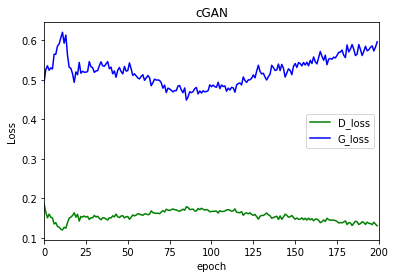

In [3]:
import matplotlib.pyplot as plt
x = np.zeros(200)
for i in range(200):
    x[i] = i
plt.figure()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("cGAN")
plt.plot(x, D_loss,color='green', label = 'D_loss')
plt.plot(x, G_loss,color='blue', label = 'G_loss')
plt.xlim(0,200)
plt.legend()
plt.show()

(342, 342, 3)
(1, 1, 342, 342, 3)


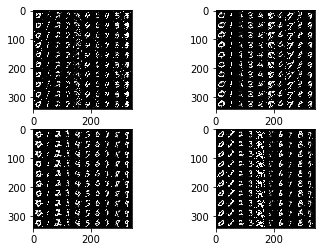

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
x50 = mpimg.imread('/home/zhizuo/271B/images/cGAN_50.png', )
x100 = mpimg.imread('/home/zhizuo/271B/images/cGAN_100.png')
x150 = mpimg.imread('/home/zhizuo/271B/images/cGAN_150.png')
x200 = mpimg.imread('/home/zhizuo/271B/images/cGAN_200.png')

x = np.array([[x50]])
print(x.shape)
plt.figure()
plt.subplot(2,2,1)
plt.imshow(x50)
plt.subplot(2,2,2)
plt.imshow(x100)
plt.subplot(2,2,3)
plt.imshow(x150)
plt.subplot(2,2,4)
plt.imshow(x200)
plt.show()